In [1]:
#standard packages
import pandas as pd
import numpy as np
#package for loop load time bar
from tqdm import tqdm
#statistical and machine learning packages
import scipy as sp
from sklearn.preprocessing import OneHotEncoder

#import scoring for machine learning
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm



#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder

# packages for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
#command to have graphs display in notebook
%matplotlib inline

In [2]:
#loading user order information
instacart_file=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
df_orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [4]:
#capture the last order information for each user
g = df_orders.groupby('user_id')
data_p1=g.last()
data_p1['order_from_last']=1

In [5]:
#capture the second to last order information for each user
data_p2=g.nth(-2)
data_p2['order_from_last']=2

In [6]:
#capture the third to last order information for each user
data_p3=g.nth(-3)
data_p3['order_from_last']=3

In [7]:
#capture the fourth to last order information for each user
data_p4=g.nth(-4)
data_p4['order_from_last']=4

In an effort to save computation time, we will work first with a much smaller portion of the data. At the end of the notebook we will attempt to use as much as our system will allow.

## Concern: 
An issue with data wrangling is deciding how to preserve the time component of order history of the customer. I originally sought to segregate the data by breaking it into chunks by order: the test data is the customer's 2nd previous order, the training data the customer’s the 3rd and 4th previous orders together then splitting on it to cross validate. I then test on the 2nd to previous order as the test set. This was taking way to much time to run. I've adjust to a small test run below. The training data is only a small portion 150 cutomer orders from the 3rd previous order they made. The test set is the customers 2nd previous order. ( The most current previous order did not have lavels for all customers, hence, I choose to move to the customers 2nd previous order).

I feel like this should work on a much larger set. This data come from a kaggle competition so I feel like I shouldn't have to reduce as much as I am. Thoughts on how I'm approaching the data set up wrong? Insights in how to reduce run time to maximize data usage? 

# The small set test drive

In [8]:
#capture the third to last order information for each user
data_p3=data_p3.reset_index()

#loading product reorder information
instacart_file2=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/order_products__prior.csv')
df_prod_orders=pd.DataFrame(instacart_file2,)
df_prod_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
#loading information for product names
instacart_products=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/products.csv')
df_prod=pd.DataFrame(instacart_products,)
df_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
#add reorder information to training data
df_train=pd.merge(df_prod_orders,data_p3, how= 'inner',left_on="order_id", right_on='order_id')
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,7,34050,1,0,142903,30.0,prior,2,14,11,3
1,7,46802,2,0,142903,30.0,prior,2,14,11,3
2,16,9755,1,1,174840,13.0,prior,3,12,18,3
3,16,25466,2,0,174840,13.0,prior,3,12,18,3
4,16,45437,3,0,174840,13.0,prior,3,12,18,3


In [11]:
#check to make sure NaN is taken care of 
df_train.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
days_since_prior_order    False
eval_set                  False
order_dow                 False
order_hour_of_day         False
order_number              False
order_from_last           False
dtype: bool

In [12]:
#see how many products and users we have 
df_train.nunique()

order_id                  206209
product_id                 42505
add_to_cart_order            100
reordered                      2
user_id                   206209
days_since_prior_order        31
eval_set                       1
order_dow                      7
order_hour_of_day             24
order_number                  97
order_from_last                1
dtype: int64

In [13]:
#sample 150 customers to make predictions for 
small_train=df_train.sample(550)
small_train.nunique()

order_id                  550
product_id                472
add_to_cart_order          34
reordered                   2
user_id                   550
days_since_prior_order     31
eval_set                    1
order_dow                   7
order_hour_of_day          24
order_number               63
order_from_last             1
dtype: int64

In [14]:
#data frame to ensure we have the same users in the test set
sample=pd.DataFrame(small_train['user_id'])

#capture the second to last order information for each user as a test set
data_p2=g.nth(-2)
data_p2['order_from_last']=2
data_p2=data_p2.reset_index()

#for test set add in reorder information
df_test=pd.merge(df_prod_orders,data_p2, how= 'inner',left_on="order_id", right_on='order_id')

#since we have train and test data broken apart by user previous order we can ensure we test only the users we trained for
small_test=pd.merge(df_test,sample, how= 'inner',left_on="user_id", right_on='user_id')
small_test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,3128,4605,1,1,197075,14.0,prior,0,9,25,2
1,3128,24184,2,1,197075,14.0,prior,0,9,25,2
2,3128,22395,3,1,197075,14.0,prior,0,9,25,2
3,3128,5115,4,1,197075,14.0,prior,0,9,25,2
4,3128,884,5,0,197075,14.0,prior,0,9,25,2


In [15]:
#small_test=df_test.sample(150)
small_test.nunique()

order_id                   550
product_id                3812
add_to_cart_order           49
reordered                    2
user_id                    550
days_since_prior_order      31
eval_set                     1
order_dow                    7
order_hour_of_day           22
order_number                63
order_from_last              1
dtype: int64

## Now we prep the feature columns to be in an appropriate format to utilize sklearn api 

In [16]:
#use pandas one hot encoder on training data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_train['order_dow'],prefix='day')
#add reorder information to training data
train=pd.merge(small_train,df_dow, how= 'inner',left_index= True, right_index=True)
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
1660380,2685103,46949,9,1,192899,12.0,prior,5,22,11,3,0,0,0,0,0,1,0
224393,365945,21560,18,1,196158,15.0,prior,0,8,21,3,1,0,0,0,0,0,0
111037,181484,32700,8,0,203778,27.0,prior,2,22,2,3,0,0,1,0,0,0,0
59517,97572,42768,2,0,97646,8.0,prior,1,20,3,3,0,1,0,0,0,0,0
570102,926950,46346,9,0,190497,18.0,prior,6,6,12,3,0,0,0,0,0,0,1


In [17]:
#use pandas one hot encoder on test data's order_dow with added 'day' to column name 
df_dow=pd.get_dummies(small_test['order_dow'],prefix='day')
#add reorder information to training data
test=pd.merge(small_test,df_dow, how= 'inner',left_index= True, right_index=True)
test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,3128,4605,1,1,197075,14.0,prior,0,9,25,2,1,0,0,0,0,0,0
1,3128,24184,2,1,197075,14.0,prior,0,9,25,2,1,0,0,0,0,0,0
2,3128,22395,3,1,197075,14.0,prior,0,9,25,2,1,0,0,0,0,0,0
3,3128,5115,4,1,197075,14.0,prior,0,9,25,2,1,0,0,0,0,0,0
4,3128,884,5,0,197075,14.0,prior,0,9,25,2,1,0,0,0,0,0,0


In [18]:
#capture feature names and make a list
features=train[['add_to_cart_order', 'days_since_prior_order', 'order_dow','order_hour_of_day', 'order_number', 'order_from_last', 'day_0','day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']]
feature_list = list(features.columns)
features=features.columns


#make a training set for sklearn features
xtrain = train[features]

#make a test set for sklearn features
xtest = test[features]

#convert target column into array for training set
ytrain = pd.factorize(small_train['reordered'])[0]

#convert target column into array for test set 
ytest = pd.factorize(small_test['reordered'])[0]


In [19]:
#see if the training data has the proper balance of reorders 
print ('% reorders in training set {:2f}'.format(float(ytrain.sum())/ytrain.size))
print ('% reorders in test set {:2f}'.format(float(ytest.sum())/ytest.size))

% reorders in training set 0.470909
% reorders in test set 0.404326


# Question
Should I be concerned about the difference here in imbalance here? The EDA of all the data showed that reorders occured at 60% overall. Here in the training set, which is all the 3rd previous orders for customers the reorder rate  and the test set are also different. 

# Question:
What is to long for a runtime? This one, the randomized grid search, takes a few hours in the full set I would like to run.


## Now we use svm with rbf kernel on the data to make predictions for reorders

In [20]:
#to tune parameters 
clf=svm.SVC(kernel='rbf')

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

Accuracy on training data: 0.96
Accuracy on test data: 0.62
F1 Score on train data: 0.9597
F1 Score on validation (train-test set) data: 0.4599
             precision    recall  f1-score   support

          0       0.66      0.78      0.71      4489
          1       0.55      0.40      0.46      3047

avg / total       0.61      0.62      0.61      7536



   # I should tune parametes here. Definitely overfitting
   
   SVM does not have predict_proba module. We can instead plot the distance from the decision line.
   Can plot a histogram od the decision function. Need to work on making plot of the decision function on the plane. 
   See if I can plot the support vectors as well.


In [21]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [22]:
#look at confusion matrix
confusion_matrix( ytest , preds_svm )

array([[3504,  985],
       [1843, 1204]])

(array([  125.,   598.,  1180.,  2653.,  1175.,   696.,   499.,   336.,
          219.,    55.]),
 array([-1.11598277, -0.87321556, -0.63044835, -0.38768114, -0.14491393,
         0.09785328,  0.34062049,  0.58338771,  0.82615492,  1.06892213,
         1.31168934]),
 <a list of 10 Patch objects>)

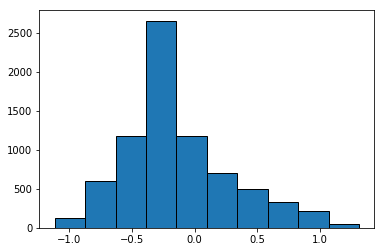

In [23]:
#can look at decision line 
clf.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf.decision_function(xtest),edgecolor='k')

## Now look at model measurements: ROC Curve, Precision-Recall Curves and AUC 

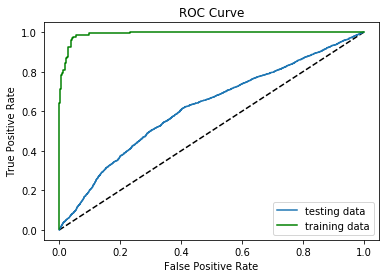

In [24]:
#predict the probabilities for each observation in training set
#pred_train_prob_svm = clf.decision_function(xtrain)[:,1]

#predict the probabilities for each observation in test set
#pred_prob_svm = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , clf.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , clf.decision_function(xtest))

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

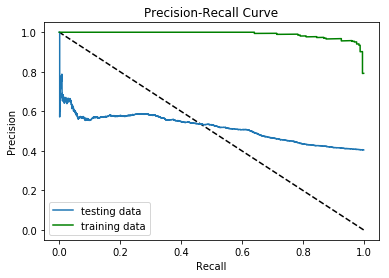

In [25]:
xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , clf.decision_function(xtrain) )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , clf.decision_function(xtest))

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [26]:
roc_auc_score(ytest , clf.decision_function(xtest))

0.61944516965695895

In [ ]:
cv_auc_scores=cross_val_score(clf, xtrain , ytrain, cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.58279009  0.61041114  0.56399204  0.6127321   0.60750507]


## The above was with default settings lets tune the model and see if we can imporve.

In [ ]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)

parameters = {'C': C_range , 'gamma' : gamma_range }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv= cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Question:
Does my approach at cross-validation voilate any principles? Do you see anything wrong here? Can I do it better?

In [ ]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

In [ ]:
#to tune parameters 
clf=svm.SVC( kernel='rbf', C= best_c , gamma= best_gamma )

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

In [ ]:
#can look at decision line 
clf.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf.decision_function(xtest),edgecolor='k' )
#add labels
plt.xlabel("Distance from Boundry Line")
plt.ylabel("Samples")
plt.title('SVM Decision Funciton Histogram')
plt.legend(loc=3)
plt.show()


#plot ROC curve 
#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , clf.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , clf.decision_function(xtest) )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

#plot the precision-recall curve for tuned model
#get values for training set
xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , clf.decision_function(xtrain) )
#get values for test set
prec_score,recall_score,thresholds=precision_recall_curve( ytest , clf.decision_function(xtest))

#plot lines
plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#add labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()
         
print( 'roc_auc_score',roc_auc_score(ytest , clf.decision_function(xtest))  )

## Improvements to make later: add one hot encode to hod column, scale/normalize all features, cross validate the auc scores, plot decision boundry on plane, add feature engineering...

# Next Random Forest 
the mini version

In [ ]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(20,40),'max_features':['auto',1,2,3,4,5]}

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

## Question
How do you pick the appropriate range for # of trees? The best # of trees was at the top range of trees. I’m thinking the model will always want the top number (its overfitting).  Should I also tune the gini purity or the minimum leaf node parameter? What all do you recommend to tune in the random forest? 

Model is overfitting on training data (.86 compared to .61). Could look at tuning the gini-index (or leaf node min).


In [ ]:
#save best parameters to use on test set
best_n = rs.best_params_['n_estimators'] 
best_features=rs.best_params_['max_features'] 

#print best parameter results
print("the best number of trees is {} with a maximum number of features of {}".format(best_n,best_features))
print("the best f1 score with these is {}".format(rs.best_score_))

In [ ]:
#create classifier from best parameters out of grid search
clf=rs.best_estimator_
#fit classifier to validation set
clf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf.predict(xtrain)

#make some predictions
preds_rf = clf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

In [ ]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

In [ ]:
#Capture model feature importance 
importances=clf.feature_importances_

In [ ]:
#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout

In [ ]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

In [ ]:

xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [ ]:
roc_auc_score(ytest , pred_prob_rf)

In [ ]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

# Concern:
The Kaggle competition best f1 score was around .409. I have my output slightly different. How can I be doing so much better with such little feature engineering? I feel like I must be doing something wrong here. 

# ignore below. Mostly larger sets that was taking to much computation time.

## Concern:

I've been trying to make a good decision on how to handle the data. If I want to one hot encode all the product_ids then I need to reduce the customer base for memory limit uses. My reason for thinking this is to compare the against the single vector decomposition I started with. I'm thinking now, I should disregard that line of evaluation and build on this random forest with better feature columns. I would then have to adjust the SVM to be similiar.

Another issue with data wrangling is deciding how to preserve the time component of order history of the customer. I originally sought to segregate the data by breaking it into chunks by order: the test data the last order the validation set the customer's 2nd previous order, and the training data the customer's 3rd previous order (you see that above). Below you see my final decision, lumping the 3rd and 4th previous orders together into the training set, spliting on it to cross validate. Then testing on the 2nd to previous order as the test set. (The last order for each customer did not all contain labels to test against, hence I choose to move a step further down the customer's order history timeline.) 
 
This is one reason my data wrangling paper has been delayed. I've been trying to decide how to set up the RF, and SVM to handle it. 

## Question:

Does my approach at cross-validation voilate any principles? Do you see anything wrong here? Can I do it better?


#set the training data to just the 4th and 3rd previous orders
data_set_train=pd.concat([data_p3,data_p4])

#reset index 
data_set_train=data_set.reset_index()

#add reorder information to training data
df_train=pd.merge(df_prod_orders,data_set_train, how= 'inner',left_on="order_id", right_on='order_id')
df_train.head()

# fill in Nan with zero
df_train=df_train.fillna(0)

#check to make sure NaN is taken care of 
df_train.isnull().any()

Data is now in the format wrangling is complete. We shall set up the data for use in sklearn. We will need to choose the features to consider and separate the labels. 

#capture feature names and make a list
features=df_train[['add_to_cart_order','days_since_prior_order','order_dow','order_from_last','order_hour_of_day','order_number']]
feature_list = list(features.columns)
features=features.columns
features

#convert target column into array for training set
ytrain = pd.factorize(df_train['reordered'])[0]
ytrain

#create test set and add reorder information 
df_test=pd.merge(df_prod_orders,data_p2, how= 'inner',left_on="order_id", right_on='order_id')
df_test.head()

#convert target column into array for test set 
ytest = pd.factorize(df_test['reordered'])[0]
ytest

#see if the training data has the proper balance of reorders 
print ('% reorders in training set {:2f}'.format(float(ytrain.sum())/ytrain.size))
print ('% reorders in test set {:2f}'.format(float(ytest.sum())/ytest.size))

## Question
Should I be concerned about the difference here in imbalance here? The EDA of all the data showed that reorders occured at 60% overall. Here in the training set, which is all the 3rd and 4th previous orders for customers the reorder rate is around 50% and the test set close to 40%. 

Below the grid search that bit to run. What is to long for a runtime? This one takes a few hours

#make a training set for sklearn features
xtrain = df_train[features]

#make a test set for sklearn features
xtest = df_test[features]

We have the data set up for sklearn lets do some machine learning. First will shall tune the parameters of the random forest classifier. Using the best parameters from cross validation, retrain the model on the training data and predict on the test data.

#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(20,40),'max_features':['auto',1,2,3,4,5]}

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

## Question: 
What is to long for a runtime? This one, the randomized grid search, takes a few hours.
How do you pick the appropriate range for # of trees? The best # of trees was at the top range of trees. I’m thinking the model will always want the top number (its overfitting).  I understand the range how to pick the range of max_features. Should I also tune the gini purity or the minimum leaf node parameter? What all do you recommend to tune in the random forest? 

## Concern:
Need to expand range on number of trees since best result was at the boundry of test ranges. (Will it always take the max here? Is it overfitting? )

#save best parameters to use on test set
best_n = rs.best_params_['n_estimators'] 
best_features=rs.best_params_['max_features'] 

#print best parameter results
print("the best number of trees is {} with a maximum number of features of {}".format(best_n,best_features))
print("the best f1 score with these is {}".format(rs.best_score_))

Parameters are tuned. We have 29 trees in the forest each using 4 out of the 6 features to learn. (need to expand in future). Next we will retrain on the training data with these parameters and predict on the test data. 

#create classifier from best parameters out of grid search
clf=rs.best_estimator_
#fit classifier to validation set
clf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf.predict(xtrain)

#make some predictions
preds_rf = clf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

## Concern:
The Kaggle competition best score was around .409. I have my output slightly different. How can I be doing so much better with such little feature engineering?

Model is overfitting on training data (.86 compared to .61). Could look at tuning the gini-index (or leaf node min). 

#look at confusion matrix
confusion_matrix( ytest , preds_rf )

Next lets take a look at which features the model used for prediciton the most. 

#make a list of feature and feature importance
list(zip(df_train[features], clf.feature_importances_))

#Capture model feature importance 
importances=clf.feature_importances_

#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout

Now lets look at the ROC and evaluations of our model

#predict the probabilities for each observation in training set
pred_train_prob_rf = clf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()


xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

roc_auc_score(ytest , pred_prob_rf)

# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

  # Now lets loow at the SVM model
  
  ## Question:
  
  Should a do a mask on the train test set?
  
  Come back and scale the features

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

rbf: \exp(-\gamma \|x-x'\|^2). \gamma is specified by keyword gamma, must be greater than 0.


When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use sklearn.model_selection.GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

Smooth models (lower gamma values) can be made more complex by selecting a larger number of support vectors (larger C values) hence the diagonal of good performing models.

The radius of the RBF kernel alone acts as a good structural regularizer. In practice though it might still be interesting to limit the number of support vectors with a lower value of C so as to favor models that use less memory and that are faster to predict.

#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(1,30),'max_features':['auto',1,2,3,4,5]}

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit(xtrain_rf,ytrain_rf)

from sklearn.pipeline import Pipeline
from sklearn import svm

#to tune parameters 
clf=svm.SVC(kernel='rbf')

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

from sklearn.pipeline import Pipeline
from sklearn import svm

#create classifier from best parameters out of grid search
#clf=rs.best_estimator_

clf=svm.SVC(kernel='rbf')

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

# should i do a pipeline

#setup steps for pipeline
steps=[('SVM',clf)] #add scale function

pipeline = Pipeline(steps)

pipeline.fit( xtrain , ytrain )

preds_svm = pipeline.predict( xtest )

print (classification_report( ytest , preds_svm ))



#look at confusion matrix
confusion_matrix( ytest , preds_svm )

#make a list of feature and feature importance
list(zip(df_train[features], clf.feature_importances_))

#Capture model feature importance 
importances=clf.feature_importances_

#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout

#predict the probabilities for each observation in training set
pred_train_prob_svm = clf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_svm = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(y train , pred_train_prob_svm )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , pred_prob_svm )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , pred_train_prob_svm )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , pred_prob_svm)

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

roc_auc_score(ytest , pred_prob_svm)

cv_auc_scores=cross_val_score(clf, xtrain , ytrain, cv=5, scoring='roc_auc')
print(cv_auc_scores)

 Train classifiers
# notes from sklearn
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# can ignore stuff below. 
working on the how to split data differently.

In [ ]:
#### below is spliting data in 

##### below if I need to reduce the data size

rf_small_train=df_rf_train.sample(750)

rf_small_table=rf_small_train.pivot(index='user_id', columns='product_id', values='reordered')

rf_small_table=rf_small_table.replace(0, 1, regex=True)
rf_small_table=rf_small_table.fillna(0)

rf_small_train=rf_small_train.set_index('user_id')

rf_small_train.head()

rf_small_sample=pd.merge(rf_small_train,rf_small_table, how= 'inner',left_index=True, right_index=True)

rf_small_sample.isnull().any()

rf_small_sample['reordered'].size

small_features=rf_small_sample.drop(['reordered','eval_set'],axis=1)
sm_feature_list = list(small_features.columns)
sm_features=small_features.columns
len(sm_feature_list)

small_features['order_id'].size

#convert target column into array
target= pd.factorize(rf_small_sample['reordered'])[0]

small_features.head()

small_features.size

clf.fit(small_features, target)

small_features.nunique()

small_features=small_features.reset_index()
small_users=pd.DataFrame(small_features['user_id'])

small_users.nunique()

small_products=pd.DataFrame(small_features['product_id'])
small_products.head()

## work on test data for predict
should i just do a train test split

need to one hotencode here for predict to be the same as model features

rf_small_sample=pd.merge(df_rf_test,small_users, how= 'inner',on='user_id')

rf_small_sample=pd.merge(rf_small_sample,small_products, how= 'inner',on='product_id')

rf_small_sample.head()

rf_small_sample.isnull().any()

rf_small_sample=rf_small_sample.reset_index('user_id')

rf_small_sample.product_id.size

rf_small_sample.nunique()

test_small_table=rf_small_sample.pivot(index='user_id',columns='product_id', values='reordered')

test_small_table=test_small_table.replace(0, 1, regex=True)
test_small_table=rf_small_table.fillna(0)

test_small_table.head()

#rf_small_train=rf_small_train.set_index('user_id')

#join one hot encode back with other features
df_rf_test

In [ ]:
#get data from test set on user_ids
#small_test=df_rf_test.merge(small_users, how='inner', on='user_id')

sm_test_features=small_test.drop(['reordered','eval_set'],axis=1)
sm_test_features.columns

small_test[small_test['user_id']==71]

sm_preds=clf.predict(sm_test_features)

clf.predict_proba(df_rf_test[features])[0:10]

#make a table of the predictions vs. the actual reorders
pd.crosstab(df_rf_test['reordered'], preds, rownames=['Actual reorder'], colnames=['Predicted reorder'])

#make a list of feature and feature importance
list(zip(df_rf_train[features], clf.feature_importances_))

importances=clf.feature_importances_

#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.tight_layout